In [2]:
import pandas as pd
from FLAI import data
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
df = pd.read_parquet('../../Data/case_1.parquet')

In [4]:
flai_dataset = data.Data(df, transform=False)

<Axes: xlabel='education', ylabel='Percent'>

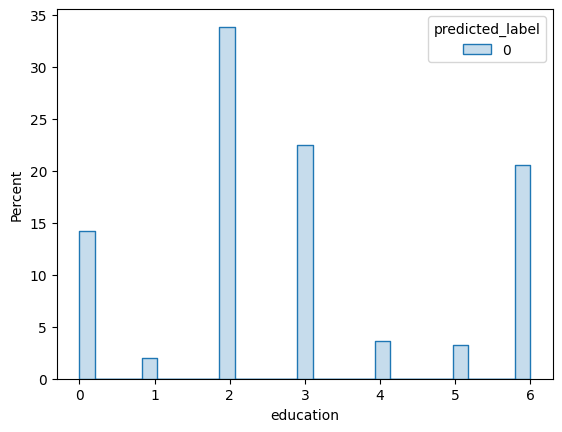

In [5]:
sns.histplot(flai_dataset.data[flai_dataset.data['sensible'] ==0], x="education", hue="predicted_label", element="step",stat="percent")



<Axes: xlabel='education', ylabel='Percent'>

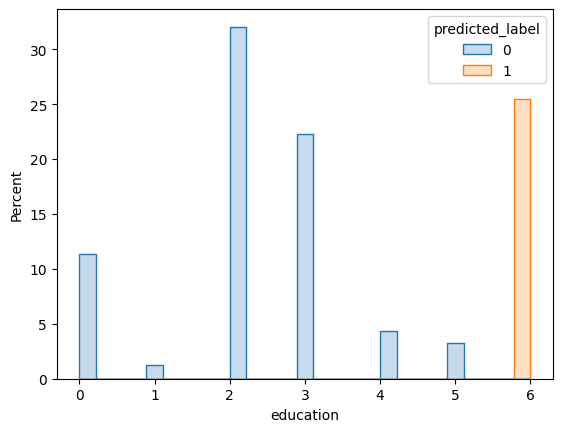

In [6]:
sns.histplot(flai_dataset.data[flai_dataset.data['sensible'] ==1], x="education", hue="predicted_label", element="step",stat="percent")


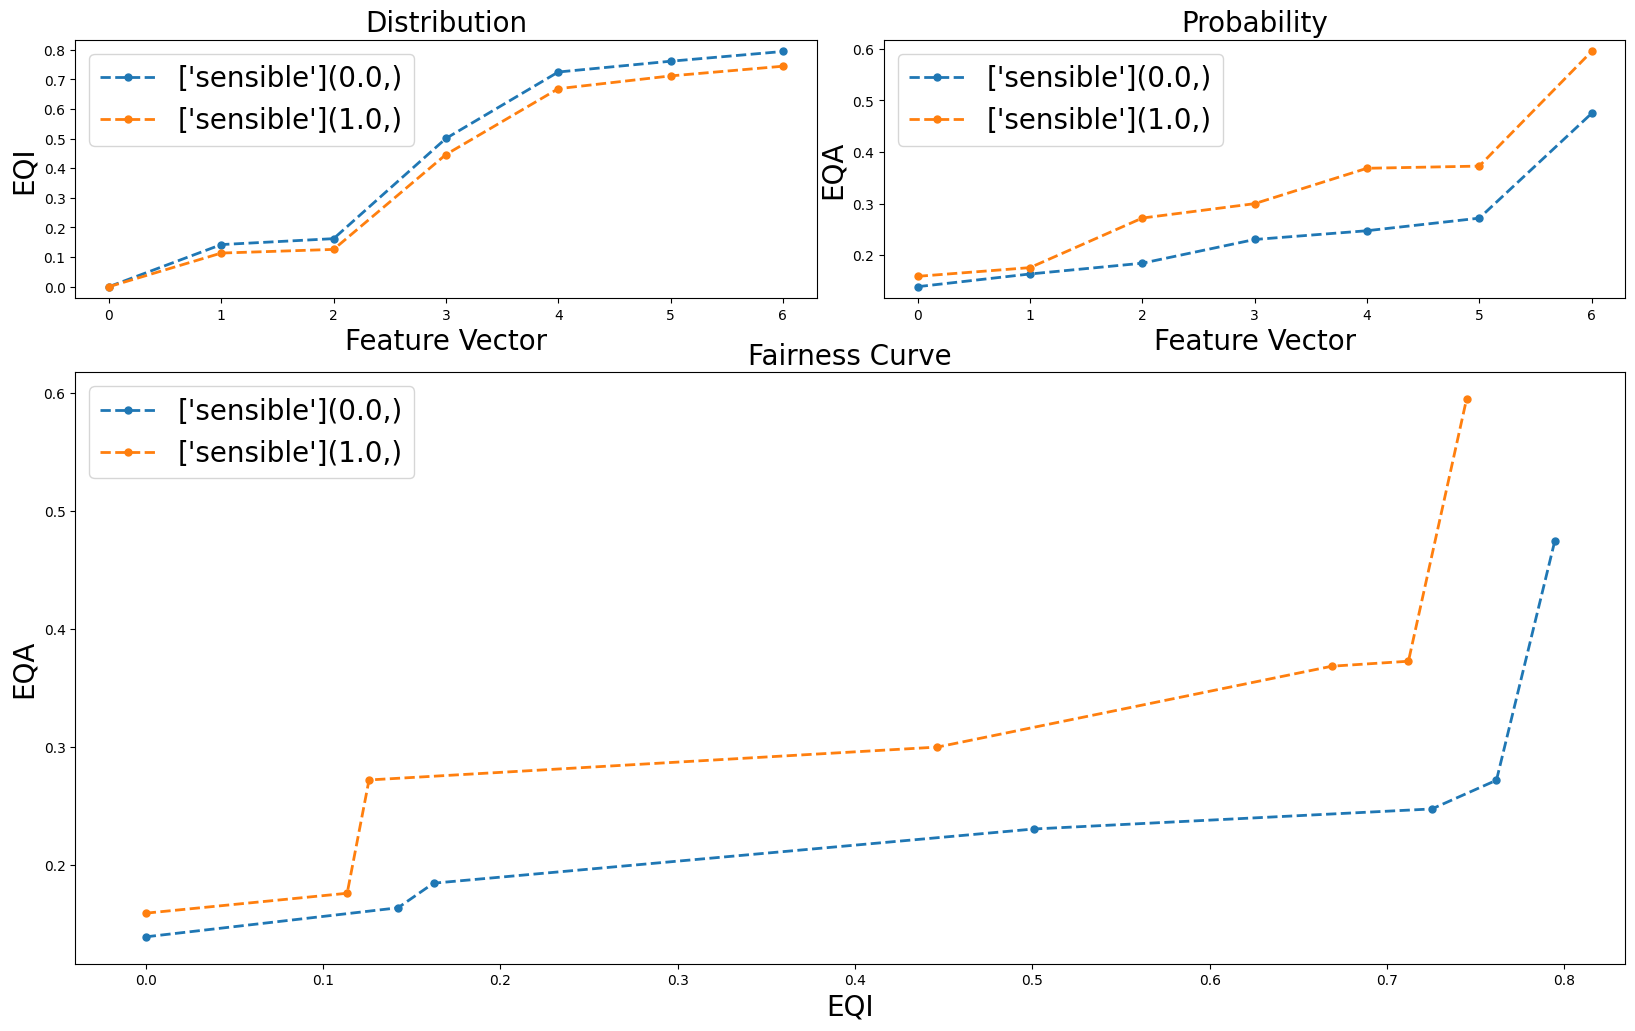

In [7]:
df_f,datos_f = flai_dataset.fairness_eqa_eqi(features = ['education'], 
                              target_column = 'proba', 
                              column_filter = ['sensible'],
                              plot = True)

In [8]:
df_f

,group,reference,EQI,EQA,F
0,"['sensible'](0.0,)","['sensible'](1.0,)",-0.04,0.08,0.09


In [9]:
data_original = flai_dataset.data.copy()

In [10]:
result_metrics = flai_dataset.fairness_metrics(target_column='label', predicted_column = 'predicted_label',
                            columns_fair = {'sensible' : {'privileged' : 1, 'unprivileged' : 0},
                                           #'race' : {'privileged' : 1, 'unprivileged' : 0}
                                           })
df_performance,df_fairness = flai_dataset.get_df_metrics(metrics_json=result_metrics)

Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0


In [11]:
df_fairness

,EOD,DI,SPD,OD
sensible_fair_metrics,-0.497313,0.0,-0.25516,-0.67003


In [12]:
df_compare = pd.DataFrame(columns = ['EOD', 'DI', 'SPD', 'OD','ACC', 'EQI', 'EQA', 'F'])
df_compare.loc['original', ['EOD', 'DI', 'SPD', 'OD']] = df_fairness.values[0].tolist()
df_compare.loc['original', [ 'EQI', 'EQA', 'F']] = df_f[['EQI', 'EQA', 'F']].values[0].tolist()
df_compare.loc['original', [ 'ACC']] = df_performance.loc['model']['ACC']

## Mitigation EQA

In [13]:
for p in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    flai_dataset.data['proba'] = data_original.proba + ((data_original.proba_b - data_original.proba) * p)
    flai_dataset.data['Predicted_s'] = (flai_dataset.data['proba'] >= 0.5) + 0
    result_metrics = flai_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted_s',
                            columns_fair = {'sensible' : {'privileged' : 1, 'unprivileged' : 0},
                                           #'race' : {'privileged' : 1, 'unprivileged' : 0}
                                           })
    df_performance,df_fairness = flai_dataset.get_df_metrics(metrics_json=result_metrics)
    df_f,_ = flai_dataset.fairness_eqa_eqi(features = ['education'], 
                                  target_column = 'proba', 
                                  column_filter = ['sensible'],
                                  plot = False)   
    df_compare.loc['eqa_'+str(p), ['EOD', 'DI', 'SPD', 'OD']] = df_fairness.values
    df_compare.loc['eqa_'+str(p), [ 'EQI', 'EQA', 'F']] = df_f[['EQI', 'EQA', 'F']].values[0].tolist()
    df_compare.loc['eqa_'+str(p), [ 'ACC']] = df_performance.loc['model']['ACC']

Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensi

In [14]:
df_compare

,EOD,DI,SPD,OD,ACC,EQI,EQA,F
original,-0.497313,0.0,-0.25516,-0.67003,0.758548,-0.04,0.08,0.09
eqa_0.1,-0.497313,0.0,-0.25516,-0.67003,0.758548,-0.04,0.07,0.08
eqa_0.2,-0.497313,0.0,-0.25516,-0.67003,0.758548,-0.04,0.06,0.07
eqa_0.3,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.05,0.06
eqa_0.4,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.05,0.06
eqa_0.5,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.04,0.06
eqa_0.6,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.03,0.05
eqa_0.7,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.02,0.04
eqa_0.8,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.02,0.04
eqa_0.9,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.01,0.04


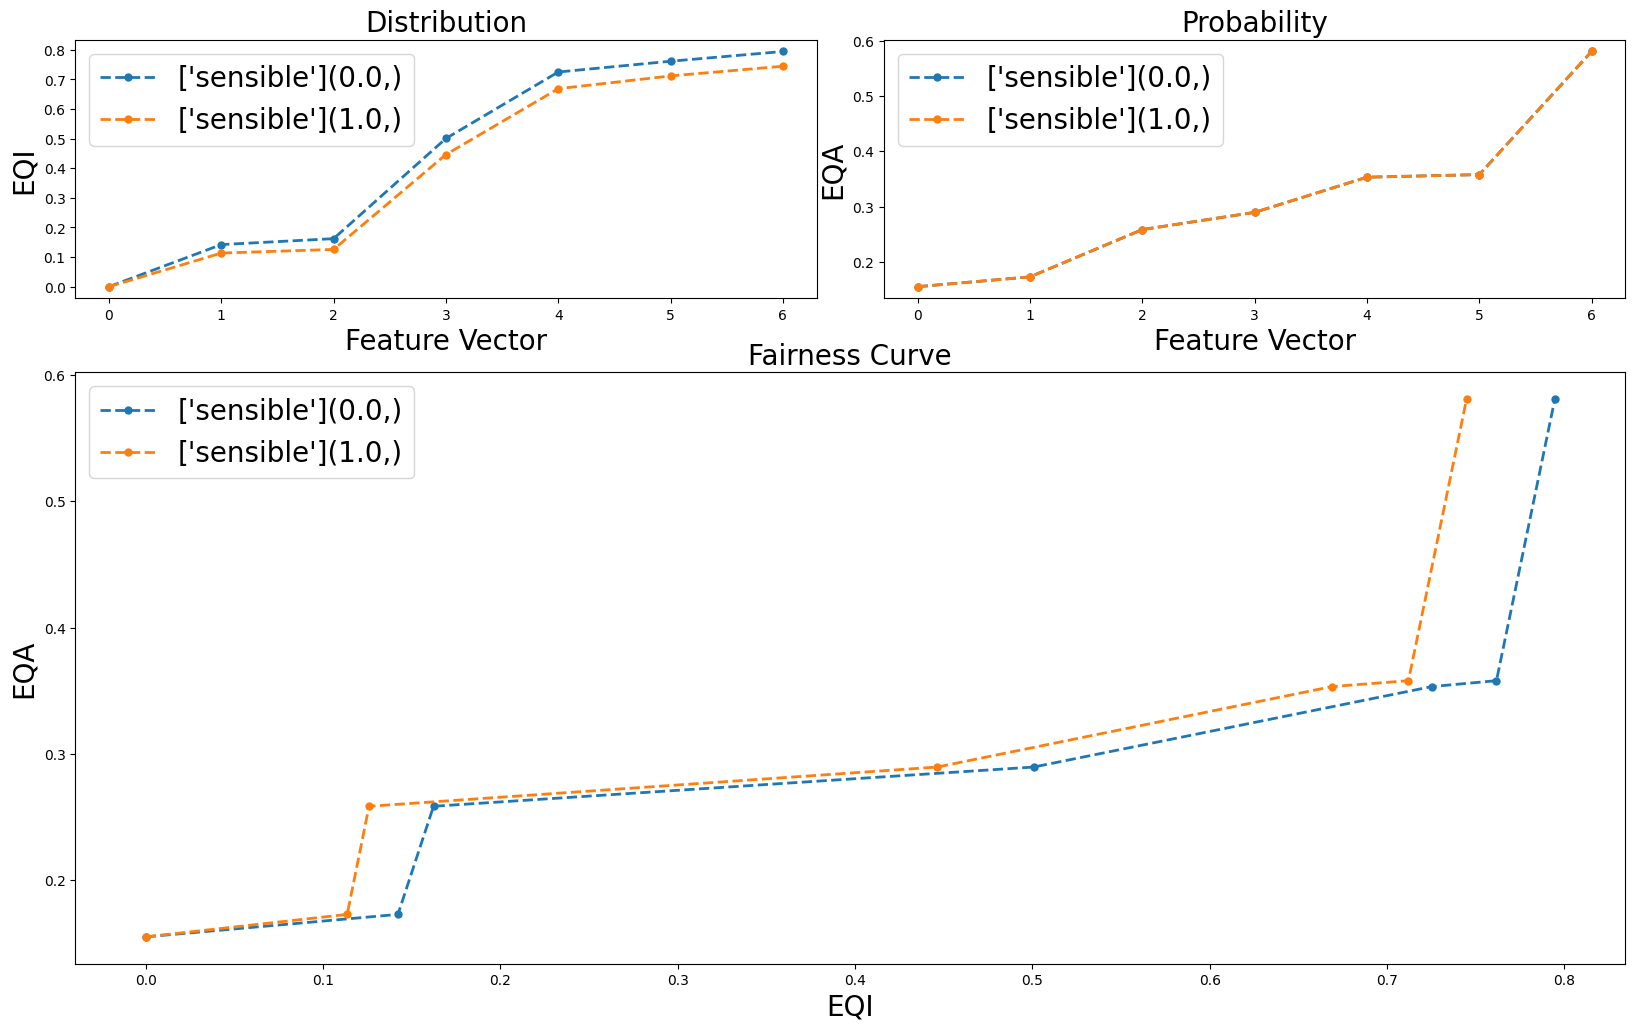

In [15]:
df_f,_ = flai_dataset.fairness_eqa_eqi(features = ['education'], 
                                  target_column = 'proba', 
                                  column_filter = ['sensible'],
                                  plot = True)  

## Mitigation EQI

In [16]:
datos_f_original_v0 = datos_f.copy()
datos_f_original_v0['eqi'] = (datos_f_original_v0['dx_1'] - datos_f_original_v0['dx_0']).values
datos_f_original_v0['n_move'] = np.round(datos_f_original_v0['eqi'] * data_original[data_original['sensible']==0].shape[0],0)
datos_f_original_v0['n_max'] = datos_f_original_v0.count_0.cumsum()
datos_f_original_v0

,count,sum,px,dx,px_0,count_0,dx_0,px_1,count_1,dx_1,eqi,n_move,n_max
education,,,,,,,,,,,,,
0.0,5751,893.1,0.155295,0.000000,0.138729,1007.0,0.000000,0.158811,4744.0,0.000000,0.000000,0.0,1007.0
1.0,657,113.7,0.173059,0.117747,0.163380,142.0,0.142232,0.175728,515.0,0.113596,-0.028636,-203.0,1149.0
2.0,15784,4081.4,0.258578,0.131199,0.184272,2397.0,0.162288,0.271883,13387.0,0.125928,-0.036360,-257.0,3546.0
3.0,10878,3150.8,0.289649,0.454363,0.230271,1589.0,0.500847,0.299806,9289.0,0.446482,-0.054365,-385.0,5135.0
4.0,2061,728.1,0.353275,0.677081,0.247287,258.0,0.725282,0.368441,1803.0,0.668910,-0.056373,-399.0,5393.0
5.0,1601,573.1,0.357964,0.719278,0.271674,233.0,0.761723,0.372661,1368.0,0.712083,-0.049640,-351.0,5626.0
6.0,12110,7031.0,0.580595,0.752058,0.474828,1454.0,0.794633,0.595026,10656.0,0.744840,-0.049793,-353.0,7080.0


In [17]:
for p in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:

    flai_dataset.data = data_original.copy()
    for n in range(1,datos_f_original_v0.shape[0],1):


        if datos_f_original_v0.n_move.values[n] < 0:
            n_move = int(abs(datos_f_original_v0.n_move.values[n])*p)
            
            search_index = datos_f_original_v0.index.values[0:n]
            #search_index = np.array([[si2 for si2 in si] for si in search_index])
            
            data_filter = pd.DataFrame(columns = data_original.columns)
            for si in range(search_index.shape[0]):
                data_filter = pd.concat([data_filter,flai_dataset.data[(flai_dataset.data['education'] == search_index[si]) &
                             (flai_dataset.data['sensible'] == 0)]])

            data_move = data_filter.sort_values(by='proba_b',ascending=False)[0:n_move]
            flai_dataset.data.loc[data_move.index.values,[ 'education','proba_b','proba']] = [datos_f_original_v0.index.values[n],
                                                                                                              datos_f_original_v0.px.values[n],
                                                                                                              datos_f_original_v0.px_0.values[n]]    
    flai_dataset.data['Predicted_s'] = (flai_dataset.data['proba'] >= 0.5) + 0
    flai_dataset.data['Predicted_b'] = (flai_dataset.data['proba_b'] >= 0.5) + 0

    result_metrics = flai_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted_s',
                            columns_fair = {'sensible' : {'privileged' : 1, 'unprivileged' : 0},
                                           #'race' : {'privileged' : 1, 'unprivileged' : 0}
                                           })
    df_performance,df_fairness = flai_dataset.get_df_metrics(metrics_json=result_metrics)
    df_f,_ = flai_dataset.fairness_eqa_eqi(features = ['education'], 
                                  target_column = 'proba', 
                                  column_filter = ['sensible'],
                                  plot = False)   
    df_compare.loc['eqi_'+str(p), ['EOD', 'DI', 'SPD', 'OD']] = df_fairness.values
    df_compare.loc['eqi_'+str(p), [ 'EQI', 'EQA', 'F']] = df_f[['EQI', 'EQA', 'F']].values[0].tolist()
    df_compare.loc['eqi_'+str(p), [ 'ACC']] = df_performance.loc['model']['ACC']

Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensi

In [37]:
df_compare

,EOD,DI,SPD,OD,ACC,EQI,EQA,F
original,-0.497313,0.0,-0.25516,-0.67003,0.758548,-0.04,0.08,0.09
eqa_0.1,-0.497313,0.0,-0.25516,-0.67003,0.758548,-0.04,0.07,0.08
eqa_0.2,-0.497313,0.0,-0.25516,-0.67003,0.758548,-0.04,0.06,0.07
eqa_0.3,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.05,0.06
eqa_0.4,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.05,0.06
eqa_0.5,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.04,0.06
eqa_0.6,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.03,0.05
eqa_0.7,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.02,0.04
eqa_0.8,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.02,0.04
eqa_0.9,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.01,0.04


: 

: 

: 

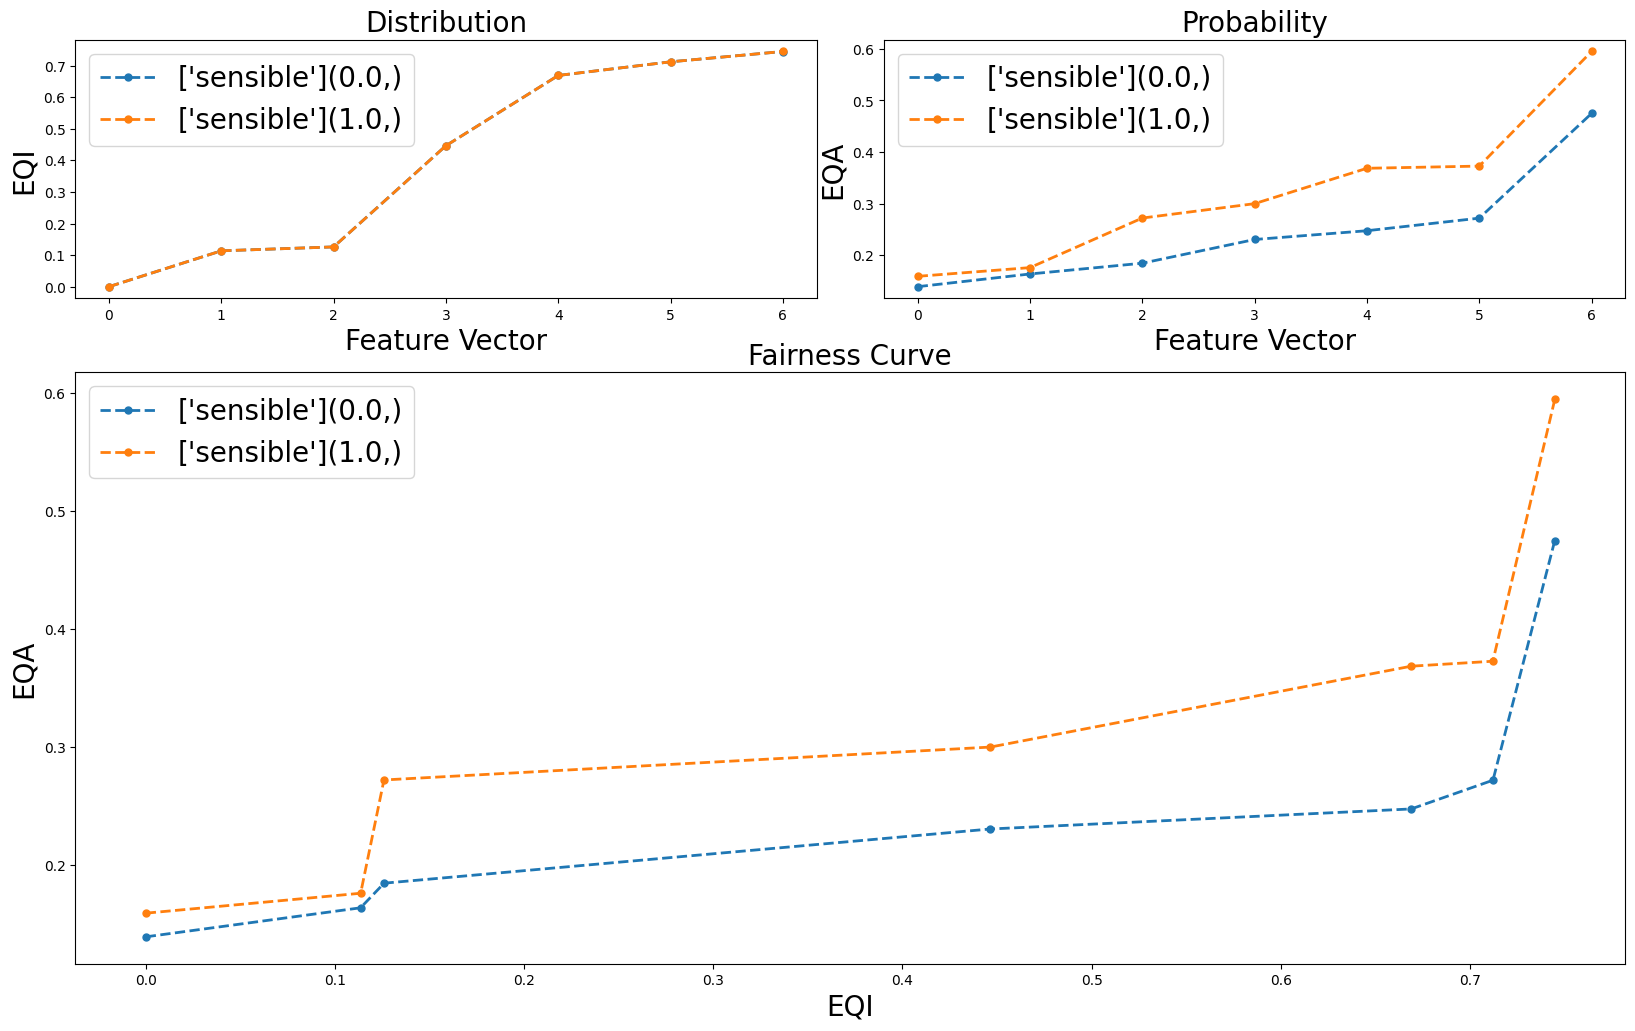

In [18]:
df_f,_ = flai_dataset.fairness_eqa_eqi(features = ['education'], 
                                  target_column = 'proba', 
                                  column_filter = ['sensible'],
                                  plot = True) 

## Mitigation EQI + EQA

In [19]:
for p in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:

    flai_dataset.data = data_original.copy()
    for n in range(1,datos_f_original_v0.shape[0],1):


        if datos_f_original_v0.n_move.values[n] < 0:
            n_move = int(abs(datos_f_original_v0.n_move.values[n])*p)
            
            search_index = datos_f_original_v0.index.values[0:n]
            #search_index = np.array([[si2 for si2 in si] for si in search_index])
            
            data_filter = pd.DataFrame(columns = data_original.columns)
            for si in range(search_index.shape[0]):
                data_filter = pd.concat([data_filter,flai_dataset.data[(flai_dataset.data['education'] == search_index[si]) &
                             (flai_dataset.data['sensible'] == 0)]])

            data_move = data_filter.sort_values(by='proba_b',ascending=False)[0:n_move]
            flai_dataset.data.loc[data_move.index.values,[ 'education','proba_b','proba']] = [datos_f_original_v0.index.values[n],
                                                                                                              datos_f_original_v0.px.values[n],
                                                                                                              datos_f_original_v0.px_0.values[n]]    
    flai_dataset.data['Predicted_s'] = (flai_dataset.data['proba'] >= 0.5) + 0
    flai_dataset.data['Predicted_b'] = (flai_dataset.data['proba_b'] >= 0.5) + 0
    
    
    flai_dataset.data['proba'] = flai_dataset.data.proba + ((flai_dataset.data.proba_b - flai_dataset.data.proba) * p)
    flai_dataset.data['Predicted_s'] = (flai_dataset.data['proba'] >= 0.5) + 0
    result_metrics = flai_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted_s',
                            columns_fair = {'sensible' : {'privileged' : 1, 'unprivileged' : 0},
                                           #'race' : {'privileged' : 1, 'unprivileged' : 0}
                                           })
    df_performance,df_fairness = flai_dataset.get_df_metrics(metrics_json=result_metrics)
    df_f,_ = flai_dataset.fairness_eqa_eqi(features = ['education'], 
                                  target_column = 'proba', 
                                  column_filter = ['sensible'],
                                  plot = False)   
    df_compare.loc['eqa_eqi_'+str(p), ['EOD', 'DI', 'SPD', 'OD']] = df_fairness.values
    df_compare.loc['eqa_eqi_'+str(p), [ 'EQI', 'EQA', 'F']] = df_f[['EQI', 'EQA', 'F']].values[0].tolist()
    df_compare.loc['eqa_eqi_'+str(p), [ 'ACC']] = df_performance.loc['model']['ACC']


Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensible  the value :  0
Calculating metrics for : sensible  the value :  1
Calculating metrics for : sensi

In [20]:
df_compare

,EOD,DI,SPD,OD,ACC,EQI,EQA,F
original,-0.497313,0.0,-0.25516,-0.67003,0.758548,-0.04,0.08,0.09
eqa_0.1,-0.497313,0.0,-0.25516,-0.67003,0.758548,-0.04,0.07,0.08
eqa_0.2,-0.497313,0.0,-0.25516,-0.67003,0.758548,-0.04,0.06,0.07
eqa_0.3,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.05,0.06
eqa_0.4,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.05,0.06
eqa_0.5,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.04,0.06
eqa_0.6,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.03,0.05
eqa_0.7,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.02,0.04
eqa_0.8,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.02,0.04
eqa_0.9,0.007317,0.804856,-0.049793,-0.013901,0.751095,-0.04,0.01,0.04


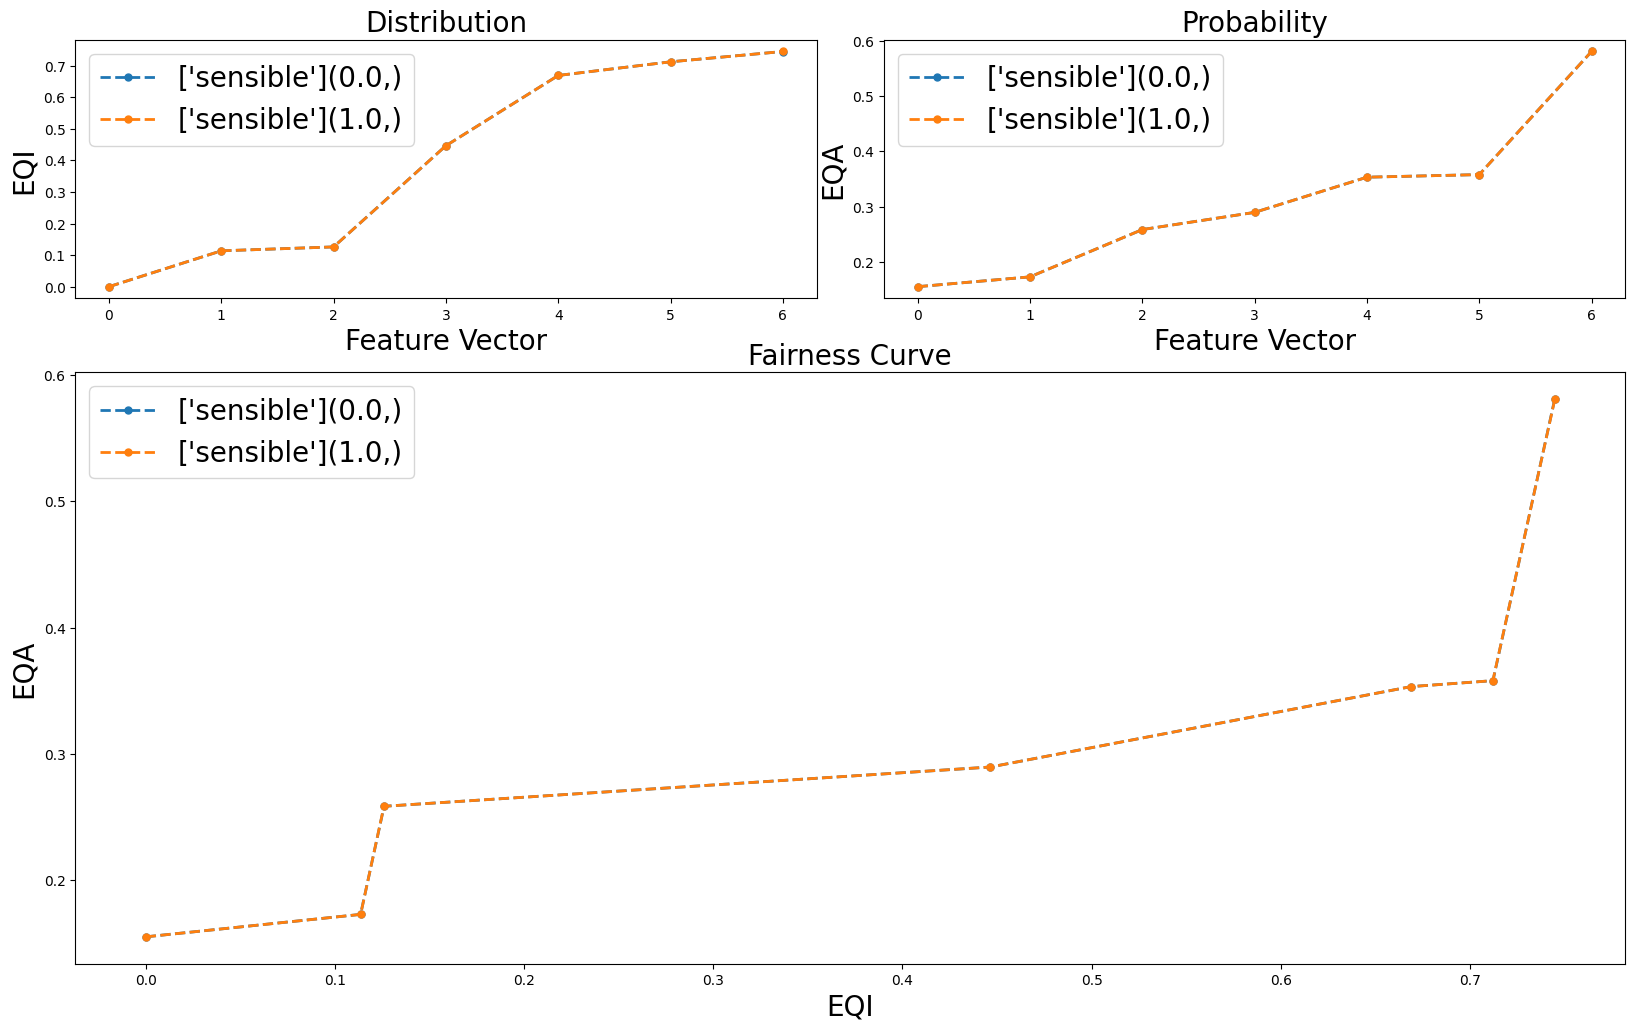

In [21]:
df_f,_ = flai_dataset.fairness_eqa_eqi(features = ['education'], 
                                  target_column = 'proba', 
                                  column_filter = ['sensible'],
                                  plot = True) 